In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy import linalg as la
import argparse
import pickle
import sys
sys.path.append("../") 
from utils_quadratic import *
import scipy.linalg  as sla
import random
%load_ext autoreload
%autoreload 2

In [2]:
rng= list(range(1, 100)) # list of integers from 1 to 99
                           # adjust this boundaries to fit your needs
random.shuffle(rng)

d = 3

A1 = np.random.randn(d, d)
Q1 = np.random.randn(d, d)
Q1 = np.dot(Q1, Q1.T)

A2 = np.random.randn(d, d)
Q2 = np.random.randn(d, d)
Q2 = np.dot(Q2,Q2.T)
eta_init = 0.01
MAXINNER = 2000
u = np.ones(d)
x0 = np.ones(2*d)

game = quadratic(Q1, Q2, A1, A2, eta_init, MAXINNER, u, d)
i=0
eigs=game.get_alpha_L(u)
alpha=min(eigs)
L=max(eigs)
eta_bound=alpha/(2*L**2)

while (game.check_jacobian(u) == False) or (game.eta_bound < 0.005) :
    np.random.seed(rng[i])
    A1 = np.random.randn(d, d)
    Q1 = np.random.randn(d, d)
    Q1 = np.dot(Q1, Q1.T) + 2*np.eye(d)

    A2 = np.random.randn(d, d)
    Q2 = np.random.randn(d, d)
    Q2 = np.dot(Q2,Q2.T) + 2*np.eye(d)
    game = quadratic(Q1, Q2, A1, A2, eta_init, MAXINNER, u, d)
    #print(game.eta_bound)
    i+=1
print(i,rng[i])

68 59


In [3]:
eigs=game.get_alpha_L(u)
alpha=min(eigs)
L=max(eigs)
eta_bound=alpha/(2*L**2)
eta_bound

0.0054070480621008

In [799]:
game.check_jacobian(u)

True

## Checking convergence of gradient descent to Nash equilibrium

In [4]:
game = quadratic(Q1, Q2, A1, A2, eta_bound, MAXINNER, u, d)

In [5]:
history_0, history_1, costs_0, cost_1 = game.runGradPlay()
nash= game.solve_nash(x0)
nash_0 = nash[0:3]
nash_1 = nash[3:6]

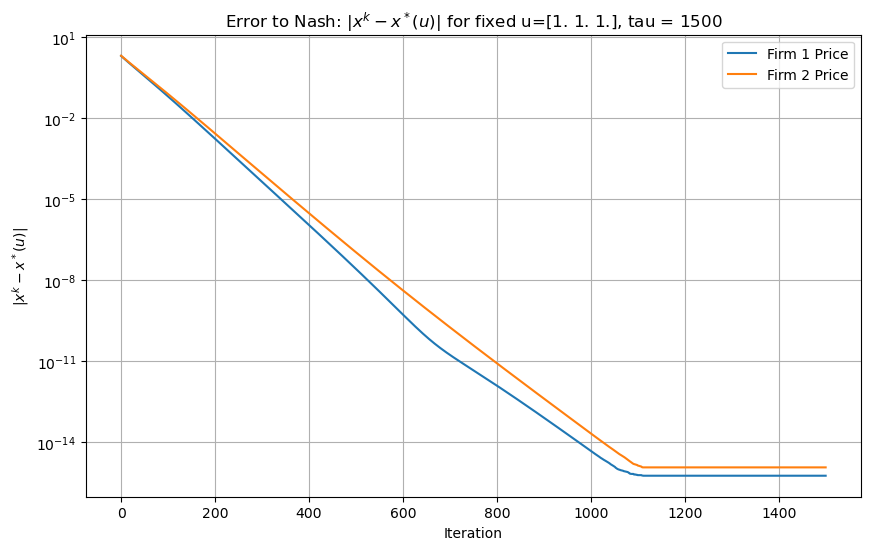

In [966]:
plt.figure(figsize=(10, 6))

plt.plot([np.linalg.norm(price- nash_0) for price in history_0], label='Firm 1 Price')
plt.plot([np.linalg.norm(price - nash_1) for price in history_1], label='Firm 2 Price')

plt.title('Error to Nash: $\|x^k-x^*(u)\|$ for fixed u='+str(u) + ', tau = ' + str(game.MAXINNER) )
plt.xlabel('Iteration')
plt.ylabel('$\|x^k-x^*(u)\|$')
plt.yscale('log') 
plt.legend()
plt.grid(True)
plt.show()

## Checking convergence of SGD

In [4]:
MAXINNER = 5000

In [5]:
game = quadratic(Q1, Q2, A1, A2, eta_bound, MAXINNER, u, d)

In [1027]:
history_0, history_1, costs_0, cost_1 = game.runSGDPlay(0.00001)
nash= game.solve_nash(x0)
nash_0 = nash[0:3]
nash_1 = nash[3:6]

In [1028]:
nash_0

array([-0.20732448, -0.25601593, -0.11805077])

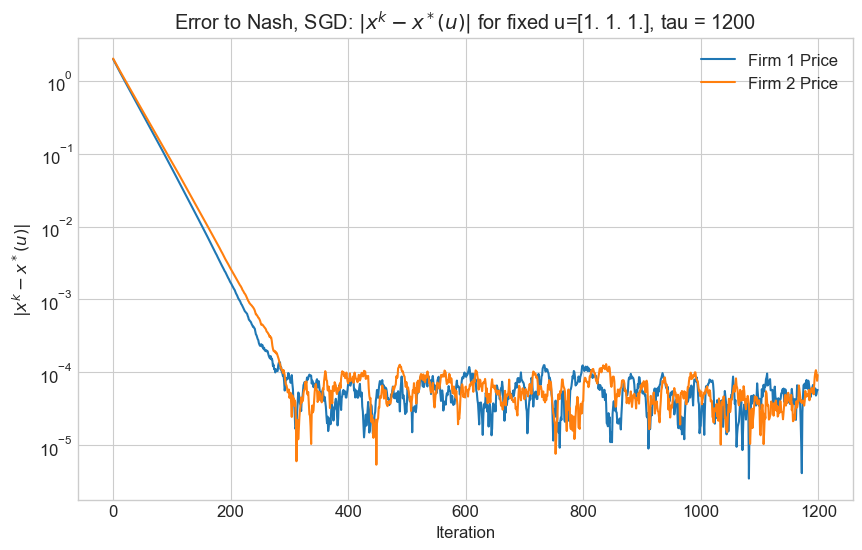

In [1029]:
plt.figure(figsize=(10, 6))

plt.plot([np.linalg.norm(price- nash_0) for price in history_0], label='Firm 1 Price')
plt.plot([np.linalg.norm(price - nash_1) for price in history_1], label='Firm 2 Price')

plt.title('Error to Nash, SGD: $\|x^k-x^*(u)\|$ for fixed u='+str(u) + ', tau = ' + str(game.MAXINNER) )
plt.xlabel('Iteration')
plt.ylabel('$\|x^k-x^*(u)\|$')
plt.yscale('log') 
plt.legend()
plt.grid(True)
plt.show()

# Running DFO

In [6]:
u_d = np.random.rand(d)
game = quadratic(Q1, Q2, A1, A2, eta_bound, MAXINNER, u_d, d)
nash= game.solve_nash(x0)
x0_d = nash[0:3]
x1_d = nash[3:6]

In [7]:
game.check_jacobian(u)

True

In [74]:
delta = 0.05
gamma_init = 5
MAXOUTER = 5000
u_init = 2*np.ones(d)
burn_in = 0
MAXINNER = 1200

num_samples = 5

## Test a single run here

In [75]:
delta

0.05

In [76]:
ix = incent(Q1, Q2, A1, A2, x0_d, x1_d, u_d, d, delta,u_init, eta_bound, gamma_init, MAXINNER, MAXOUTER, burn_in)
ix.game=quadratic(ix.Q1, ix.Q2, ix.A1, ix.A2, ix.eta, ix.MAXINNER, ix.u, ix.d)
x1s,x2s=ix.game.runGradPlay(np.ones(2*d),np.ones(d))
x1s,x2s=ix.game.runSGDPlay(np.ones(2*d),np.ones(d), var=0.001)
x1d,x2d=ix.game.get_xd_constrained(np.ones(d))


In [77]:
x1d

[array([-0.10407102, -0.189762  , -0.23110095])]

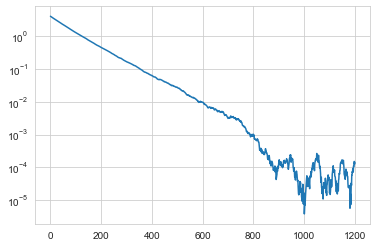

In [78]:
err1=[la.norm(x1_-x1d[0])**2 for x1_ in x1s]
plt.plot(err1)
plt.yscale('log')

In [89]:
incent_control = incent(Q1, Q2, A1, A2, x0_d, x1_d, u_d, d, delta,u_init, eta_bound, gamma_init, MAXINNER, MAXOUTER, burn_in)
loss_history, u_history, x_history, play_loss = incent_control.runDFOSGD(np.ones(2*d), 0.001 )

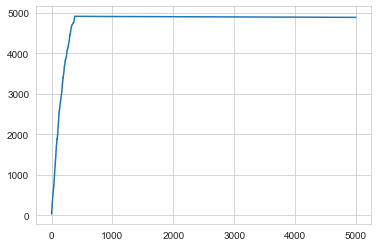

In [88]:
plt.plot(np.cumsum(play_loss))

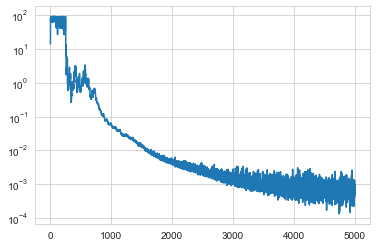

In [82]:
plt.plot(loss_history)
plt.yscale('log')

In [120]:
ix = incent(Q1, Q2, A1, A2, x0_d, x1_d, u_d, d, delta,u_init, eta_bound, gamma_init, MAXINNER, MAXOUTER, burn_in)
u0=np.hstack((u_init,u_init))
#print(u0, np.ones(2*d))
data=ix.runIncentRGM(u0, np.ones(2*d), tag='SGD')

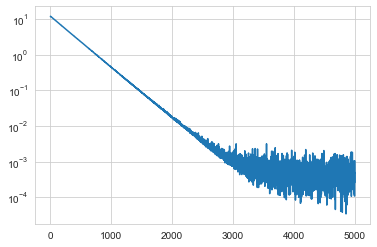

In [121]:
plt.plot(data['err'])
plt.yscale('log')

$$\begin{align*}
F(u)=&\begin{bmatrix} u_1\\ u_2\end{bmatrix}^\top G^{-\top}\begin{bmatrix} Q_1 & A_1\\ A_2^\top& Q_2\end{bmatrix}G^{-1}\begin{bmatrix} u_1\\ u_2\end{bmatrix}
-\begin{bmatrix} u_1\\ u_2\end{bmatrix}^\top G^{-1}\begin{bmatrix} u_1\\ u_2\end{bmatrix}
+\frac{\lambda}{2}\left(\begin{bmatrix} u_1\\ u_2\end{bmatrix}-\begin{bmatrix} u_1^d\\ u_2^d\end{bmatrix}\right)^\top\left(\begin{bmatrix} u_1\\ u_2\end{bmatrix}-\begin{bmatrix} u_1^d\\ u_2^d\end{bmatrix}\right)\\
=&\begin{bmatrix} u_1\\ u_2\end{bmatrix}^\top G^{-\top}\begin{bmatrix} Q_1 & A_1\\ A_2^\top& Q_2\end{bmatrix}G^{-1}\begin{bmatrix} u_1\\ u_2\end{bmatrix}
-\begin{bmatrix} u_1\\ u_2\end{bmatrix}^\top G^{-1}\begin{bmatrix} u_1\\ u_2\end{bmatrix}\\
&\quad+\frac{\lambda}{2}\begin{bmatrix} u_1\\ u_2\end{bmatrix}^\top\begin{bmatrix} u_1\\ u_2\end{bmatrix}+\frac{\lambda}{2}\begin{bmatrix} u_1^d\\ u_2^d\end{bmatrix}^\top\begin{bmatrix} u_1^d\\ u_2^d\end{bmatrix}-\lambda \begin{bmatrix} u_1^d\\ u_2^d\end{bmatrix}^\top\begin{bmatrix} u_1\\ u_2\end{bmatrix}\\
=&\begin{bmatrix} u_1\\ u_2\end{bmatrix}^\top\left(G^{-\top}\begin{bmatrix} Q_1 & A_1\\ A_2^\top& Q_2\end{bmatrix}G^{-1}+\frac{\lambda}{2}I-G^{-1}\right)\begin{bmatrix} u_1\\ u_2\end{bmatrix}+\frac{\lambda}{2}\begin{bmatrix} u_1^d\\ u_2^d\end{bmatrix}^\top\begin{bmatrix} u_1^d\\ u_2^d\end{bmatrix}-\lambda \begin{bmatrix} u_1^d\\ u_2^d\end{bmatrix}^\top\begin{bmatrix} u_1\\ u_2\end{bmatrix}\\
=&\begin{bmatrix} u_1\\ u_2\end{bmatrix}^\top\left(G^{-\top}+\frac{\lambda}{2}I-G^{-1}\right)\begin{bmatrix} u_1\\ u_2\end{bmatrix}+\frac{\lambda}{2}\begin{bmatrix} u_1^d\\ u_2^d\end{bmatrix}^\top\begin{bmatrix} u_1^d\\ u_2^d\end{bmatrix}-\lambda \begin{bmatrix} u_1^d\\ u_2^d\end{bmatrix}^\top\begin{bmatrix} u_1\\ u_2\end{bmatrix}
\end{align*}$$

$$\nabla_u F(u)=\left(G^{-\top}\begin{bmatrix} Q_1 & A_1\\ A_2^\top& Q_2\end{bmatrix}G^{-1}+\frac{\lambda}{2}I-G^{-1}\right)\begin{bmatrix} u_1\\ u_2\end{bmatrix}-\lambda \begin{bmatrix} u_1^d\\ u_2^d\end{bmatrix}=0$$

$$u^{\tt so}=\left(G^{-\top}\begin{bmatrix} Q_1 & A_1\\ A_2^\top& Q_2\end{bmatrix}G^{-1}+\frac{\lambda}{2}I-G^{-1}\right)^{-1}\frac{\lambda}{2} \begin{bmatrix} u_1^d\\ u_2^d\end{bmatrix}$$

In [123]:
A=np.random.rand(3,3)
print(A)
print(la.inv(A))
la.inv(A)-la.inv(A).T, A-A.T

[[0.12039433 0.32703841 0.77384125]
 [0.30836553 0.84608054 0.99560593]
 [0.17119057 0.6453048  0.79157675]]
[[  1.29252802  11.39916024 -15.60086631]
 [ -3.49134134  -1.76200721   5.62928202]
 [  2.56666294  -1.02882886   0.04815509]]


(array([[  0.        ,  14.89050157, -18.16752926],
        [-14.89050157,   0.        ,   6.65811088],
        [ 18.16752926,  -6.65811088,   0.        ]]),
 array([[ 0.        ,  0.01867287,  0.60265068],
        [-0.01867287,  0.        ,  0.35030114],
        [-0.60265068, -0.35030114,  0.        ]]))

In [127]:
ix.ud

array([0.19894754, 0.8568503 , 0.35165264, 0.19894754, 0.8568503 ,
       0.35165264])

In [219]:
ix = incent(Q1, Q2, A1, A2, x0_d, x1_d, u_d, d, delta,u_init, eta_bound, gamma_init, MAXINNER, MAXOUTER, burn_in, lam=0)
pslam={'ups':[], 'xps': []}
lams=np.linspace(0,2, 1000)
ud=np.hstack((ix.u_d,ix.u_d))
xn1,xn2=ix.game.get_br(np.zeros(2*d))
nash=np.hstack((xn1,xn2))
xso1,xso2=ix.game.get_br(ud)
xso=np.hstack((xso1,xso2))
lams_=[]
for lam in lams:
    ix.lam=lam
    ups=ix.get_ps()
    if not(np.any(np.abs(ups)>2)):
        xps1,xps2=ix.game.get_br(ups)
        xps=np.hstack((xps1,xps2))
        pslam['ups'].append(ups)
        pslam['xps'].append(xps)
        lams_.append(lam)

pslam['ups']=np.asarray(pslam['ups'])
pslam['xps']=np.asarray(pslam['xps'])
print(np.shape(pslam['ups']))

(876, 6)


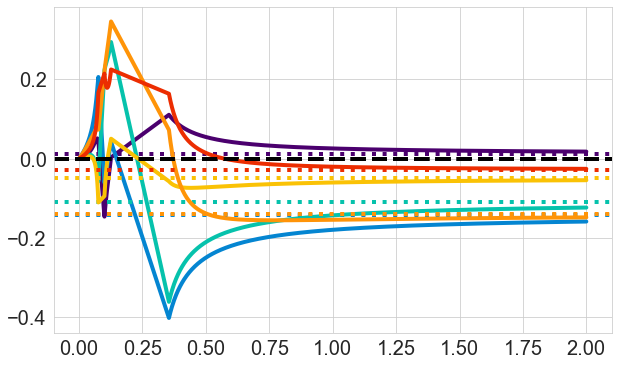

In [220]:
plt.figure(figsize=(10,6))
cols=['xkcd:royal purple', 'xkcd:cerulean', 'xkcd:turquoise', 'xkcd:goldenrod', 'xkcd:tangerine', 'xkcd:tomato red']
for i in range(2*d):
    plt.plot(lams_,pslam['xps'][:,i], color=cols[i], linewidth=4)
    plt.axhline(y=xso[i], color=cols[i], linewidth=4, linestyle=':')
    plt.axhline(y=nash[i], color='k', linewidth=4, linestyle='--')
plt.tick_params(labelsize=20)

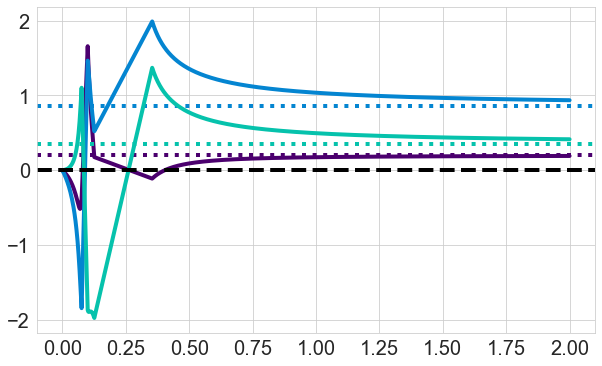

In [221]:
plt.figure(figsize=(10,6))
cols=['xkcd:royal purple', 'xkcd:cerulean', 'xkcd:turquoise', 'xkcd:goldenrod', 'xkcd:tangerine', 'xkcd:tomato red']
for i in range(d):
    plt.plot(lams_,pslam['ups'][:,i], color=cols[i], linewidth=4)

    plt.axhline(y=ud[i], color=cols[i], linewidth=4, linestyle=':')
plt.axhline(y=0, color='k', linewidth=4, linestyle='--', label='nash')
plt.tick_params(labelsize=20)

In [11]:
incent_control = incent(Q1, Q2, A1, A2, x0_d, x1_d, u_d, d, delta,u_init, eta_bound, gamma_init, MAXINNER, MAXOUTER, burn_in)
loss_history, u_history = incent_control.runDFO()
loss_history_sgd, u_history_sgd = incent_control.runDFOSGD(0.001)

In [1216]:
# plt.plot(loss_history)
# plt.yscale('log')

## Run this for deterministic GD

In [13]:
loss_history_all_us = []

# Sample u_init and run DFO for each sample
for _ in range(num_samples):
    u_init = np.random.normal(5,2, d)
    incent_control = incent(Q1, Q2, A1, A2, x0_d, x1_d, u_d, d, delta,u_init, eta_bound, gamma_init, MAXINNER, MAXOUTER, burn_in)
    loss_history, u_history = incent_control.runDFO()
    
    loss_history_all_us.append(loss_history)

# Convert list of results to a numpy array for easier analysis
loss_history_all_us = np.array(loss_history_all_us)

# Calculate mean and standard deviation
mean_results = np.mean(loss_history_all_us, axis=0)
std_results = np.std(loss_history_all_us, axis=0)

## Run this for SGD

In [14]:
loss_history_all_us_sgd = []

# Sample u_init and run DFO for each sample
for _ in range(num_samples):
    u_init = np.random.normal(5,2, d)
    incent_control = incent(Q1, Q2, A1, A2, x0_d, x1_d, u_d, d, delta,u_init, eta_bound, gamma_init, MAXINNER, MAXOUTER, burn_in)
    loss_history, u_history = incent_control.runDFOSGD(0.001)
    
    loss_history_all_us_sgd.append(loss_history)

# Convert list of results to a numpy array for easier analysis
loss_history_all_us_sgd = np.array(loss_history_all_us_sgd)

# Calculate mean and standard deviation
mean_results_sgd = np.mean(loss_history_all_us_sgd, axis=0)
std_results_sgd = np.std(loss_history_all_us_sgd, axis=0)

In [ ]:
loss_history_all_us_br = []

# Sample u_init and run DFO for each sample
for _ in range(num_samples):
    u_init = np.random.normal(5,2, d)
    incent_control = incent(Q1, Q2, A1, A2, x0_d, x1_d, u_d, d, delta,u_init, eta_bound, gamma_init, MAXINNER, MAXOUTER, burn_in)
    loss_history, u_history, _, _ = incent_control.runDFOBR(0.001)
    
    loss_history_all_us_br.append(loss_history)

# Convert list of results to a numpy array for easier analysis
loss_history_all_us_br = np.array(loss_history_all_us_sgd)

# Calculate mean and standard deviation
mean_results_br = np.mean(loss_history_all_us_br, axis=0)
std_results_br = np.std(loss_history_all_us_br, axis=0)

In [1215]:
# plt.fill_between(range(MAXOUTER + burn_in), mean_results - std_results, mean_results + std_results, color='gray', alpha=0.2, label='Mean ±1 std. dev.')
# plt.plot(range(MAXOUTER + burn_in), mean_results, label='Mean trajectory')
# for result in loss_history_all_us:
#     plt.plot(range(MAXOUTER + burn_in), result, color='blue', alpha=0.2)  # Individual trajectories

# plt.title('DFO Trajectories, $u_0 \sim \mathcal{N}(10, 2)$')
# plt.xlabel('Epochs')
# plt.ylabel('Loss, $\|x - x_d\|^2 + \|u-u_d\|^2$')
# plt.yscale('log')
# plt.legend()
# plt.show()

In [1214]:
# import matplotlib.pyplot as plt
# import matplotlib as mpl

# # Setting a light style with gridlines
# plt.style.use('seaborn-whitegrid')

# # Create a color palette
# palette = plt.get_cmap('Set1')

# # Increasing default font size
# mpl.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})

# # Adjusting figure size
# plt.figure(figsize=(10, 6))

# # Plotting
# plt.fill_between(range(MAXOUTER + burn_in), mean_results - std_results, mean_results + std_results, color='gray', alpha=0.2, label='Mean ±1 std. dev.')
# plt.plot(range(MAXOUTER + burn_in), mean_results, label='Mean trajectory', color='darkorange', linewidth=3) # Enhanced visibility for mean trajectory
# for i, result in enumerate(loss_history_all_us):
#     plt.plot(range(MAXOUTER + burn_in), result, color='blue', alpha=0.2)  # Individual trajectories

# # Adding title and labels
# #plt.title('DFO Trajectories, $u_0 \sim \mathcal{N}(10, 2)$', fontsize=16)
# plt.xlabel('Epochs', fontsize=14)
# plt.ylabel('Loss, $\|x - x_d\|^2 + \|u-u_d\|^2$', fontsize=14)

# # Setting yscale to log
# plt.yscale('log')

# # Adding legend
# plt.legend(loc='upper right')

# # Show plot
# plt.show()
# plt.savefig('dfo_sgd.png')

In [25]:
import pickle as pk 
data={
    'game': incent_control.game,
    'mean_results_sgd': mean_results_sgd,
    'std_results_sgd': std_results_sgd,
    'loss_history_all_us_sgd': loss_history_all_us_sgd,
    'loss_history_all_us': loss_history_all_us,
    'mean_results': mean_results,
    'std_results': std_results
}
pk.dump(data, open("dfo_run_v1.pk",'wb'))

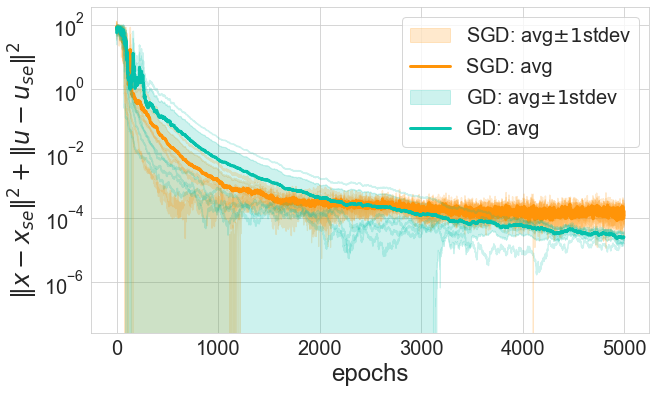

In [222]:
fs=24
import os
import seaborn as sns
sns.set_style("whitegrid")

cols=['xkcd:tangerine', 'xkcd:turquoise']
plt.figure(figsize=(10, 6))

# Plotting
plt.fill_between(range(MAXOUTER + burn_in), mean_results_sgd - std_results_sgd, mean_results_sgd + std_results_sgd, color=cols[0], alpha=0.2, label=r'SGD: avg$\pm 1$stdev')
plt.plot(range(MAXOUTER + burn_in), mean_results_sgd, label=r'SGD: avg', color=cols[0], linewidth=3) # Enhanced visibility for mean trajectory
for i, result in enumerate(loss_history_all_us_sgd):
    plt.plot(range(MAXOUTER + burn_in), result, color=cols[0], alpha=0.2)  # Individual trajectories

plt.fill_between(range(MAXOUTER + burn_in), mean_results - std_results, mean_results + std_results, color=cols[1], alpha=0.2, label='GD: avg$\pm 1$stdev')
plt.plot(range(MAXOUTER + burn_in), mean_results, label=r'GD: avg', color=cols[1], linewidth=3) # Enhanced visibility for mean trajectory
for i, result in enumerate(loss_history_all_us):
    plt.plot(range(MAXOUTER + burn_in), result, color=cols[1], alpha=0.2)  # Individual trajectories

#plt.title('DFO Trajectories, $u_0 \sim \mathcal{N}(10, 2)$', fontsize=16)
plt.xlabel('epochs', fontsize=fs)
plt.ylabel('$\Vert x - x_{se}\Vert^2 + \Vert u-u_{se}\Vert^2$', fontsize=fs)
plt.yscale('log')
plt.legend(loc='upper right', fontsize=fs-4)
plt.tick_params(labelsize=fs-4)

figpath="./figs/"
if not(os.path.exists(figpath)): os.makedirs(figpath)
for tag in ['png','pdf']:
    plt.savefig(figpath+'dfo.'+tag, transparent=True, bbox_inches='tight',dpi=300 )

### Inner Player SGD: DONT RUN THIS

In [1198]:
delta = 0.25
gamma_init = 100
MAXOUTER = 10000
u_init = 2*np.ones(d)
burn_in = 100
MAXINNER = 1200

num_samples = 10
var_inner = 0.00001

In [1199]:
loss_history_all_us = []

# Sample u_init and run DFO for each sample
for _ in range(num_samples):
    u_init = np.random.normal(5,2, d)
    incent_control = incent(Q1, Q2, A1, A2, x0_d, x1_d, u_d, d, delta,u_init, eta_bound, gamma_init, MAXINNER, MAXOUTER, burn_in)
    loss_history, u_history = incent_control.runDFOSGD(var_inner)
    
    loss_history_all_us.append(loss_history)

# Convert list of results to a numpy array for easier analysis
loss_history_all_us = np.array(loss_history_all_us)

# Calculate mean and standard deviation
mean_results = np.mean(loss_history_all_us, axis=0)
std_results = np.std(loss_history_all_us, axis=0)

[7.5534681  2.04453288 7.06511346]
SGD Distance to Nash, Burn-in
True
True
100
[-234.40918632 -913.9981821  -840.53843671]
[5. 5. 5.]
SGD Distance to Nash, Burn-in
True
True
100
[ 796.32760933 -275.98718011 -227.39256806]
[-5.  5.  5.]
SGD Distance to Nash, Burn-in
True
True
100
[-427.10814776  -20.71614054 -761.5079521 ]
[5. 5. 5.]
SGD Distance to Nash, Burn-in
True
True
100
[-186.77206714   48.4312092   863.00454703]
[ 5. -5. -5.]
SGD Distance to Nash, Burn-in
True
True
100
[341.37298725 162.58520635 896.36386715]
[-5. -5. -5.]
SGD Distance to Nash, Burn-in
True
True
100
[ -396.79139084  -406.95494278 -1008.89475055]
[5. 5. 5.]
SGD Distance to Nash, Burn-in
True
True
100
[ 268.33666929 -638.80871813  519.45582438]
[-5.  5. -5.]
SGD Distance to Nash, Burn-in
True
True
100
[ -80.44009459  -65.20909153 1039.65045658]
[ 5.  5. -5.]
SGD Distance to Nash, Burn-in
True
True
100
[ 692.29561571 -716.12947041  192.34961103]
[-5.  5. -5.]
SGD Distance to Nash, Burn-in
True
True
100
[-1101.75301

SGD Distance to Nash, Burn-in
True
True
100
[-450.36520311  128.58779987  865.41770868]
[ 5. -5. -5.]
SGD Distance to Nash, Burn-in
True
True
100
[-497.29369081  697.32827809 -474.02981338]
[ 5. -5.  5.]
SGD Distance to Nash, Burn-in
True
True
100
[-534.66801032 -369.5640939  -559.07054225]
[5. 5. 5.]
SGD Distance to Nash, Burn-in
True
True
100
[ 270.10586719  312.77712712 -753.74282396]
[-5. -5.  5.]
SGD Distance to Nash, Burn-in
True
True
100
[-431.55561817  831.23622139  -28.46955575]
[ 5. -5.  5.]
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/ksk/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/cn/wpc2vc951hs1wtznx5c_whb5kqkshb/T/ipykernel_42199/1937080780.py", line 7, in <module>
    loss_history, u_history = incent_control.runDFOSGD(var_inner)
  File "/Users/ksk/Desktop/Berkeley Year 1/Spring 2024/Decision Dependence/decision-dependence/2024ICML/ntbks/../utils_quadratic.py", line 79, in runDFOSGD
    history_0, history_1, costs_0, cost_1 = self.game.runSGDPlay(var) # Run firm gradient play
  File "/Users/ksk/Desktop/Berkeley Year 1/Spring 2024/Decision Dependence/decision-dependence/2024ICML/ntbks/../utils_quadratic.py", line 242, in runSGDPlay
    x_next1 = self.proj(self.x1 - self.eta * self.gradPlayer(0) + noise_1)
  File "/Users/ksk/Desktop/Berkeley Year 1/Spring 2024/Decision Dependence/decision-dependence/2024ICML/ntbks/../utils_quadratic.py",

In [1143]:
import numpy as np
from scipy.optimize import minimize

def objective_function(vars, Q1, Q2, A1, A2, d):
    x1, x2, u = vars[:d], vars[d:2*d], vars[2*d:3*d]
    return x1.T @ Q1 @ x1 + x1.T @ A1 @ x2 + u.T @ x1 + x2 @ Q2 @ x2 + x1.T @ A2 @ x2 + u.T @ x2 + 0.6500001*np.linalg.norm(u)

def constraint1(vars, Q1, Q2, A1, A2, d):
    x1, x2, u = vars[:d], vars[d:2*d], vars[2*d:3*d]
    return 2 * Q1 @ x1 + A1 @ x2 + u

def constraint2(vars, Q1, Q2, A1, A2, d):
    x1, x2, u = vars[:d], vars[d:2*d], vars[2*d:3*d]
    return 2 * Q2 @ x2 + A2.T@x1 + u

def optimize_system(d, Q1, Q2, A1, A2, vars0, bounds):
    # Define constraints
    con1 = {'type': 'eq', 'fun': constraint1, 'args': (Q1, Q2, A1, A2, d)}
    con2 = {'type': 'eq', 'fun': constraint2, 'args': (Q1, Q2, A1, A2, d)}
    constraints = [con1, con2]

    # Perform the optimization
    result = minimize(objective_function, vars0, args=(Q1, Q2, A1, A2, d), method='SLSQP', bounds=bounds, constraints=constraints)

    # Print the result
    print("Optimal values for x1, x2, and u:", result.x)
    print("Minimum value of the objective function:", result.fun)
    print("Optimization successful:", result.success)
    return result

d = 3
bounds_x1 = (-10, 10)  # Bounds for x1
bounds_x2 = (-10, 10)  # Bounds for x2
bounds_u = (-5, 5)  # Bounds for u

bounds = [bounds_x1] * d + [bounds_x2] * d + [bounds_u] * d

# Initial guesses for x1, x2, and u (d-dimensional vectors)
vars0 = np.random.rand(3 * d) 

# Call the optimization function
result = optimize_system(d, Q1, Q2, A1, A2, vars0, bounds)


Optimal values for x1, x2, and u: [-2.87622600e-07 -5.43607093e-08 -2.32044365e-07 -2.99878280e-07
  2.30259801e-07 -4.39498722e-07  1.41247507e-06 -8.52369100e-07
  1.60645663e-06]
Minimum value of the objective function: 1.496739254381626e-06
Optimization successful: True


In [1189]:
import pickle
with open('game_instance.pkl', 'wb') as file:
    data_to_save = {
        'Q1': Q1,
        'Q2': Q2,
        'A1': A1,
        'A2': A2,
        'x1_d': x0_d,
        'x2_d': x1_d,
        'u_d': u_d
    }
    pickle.dump(data_to_save, file)